
=== Logistic Regression ===
Accuracy: 0.9133333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       258
           1       1.00      0.38      0.55        42

    accuracy                           0.91       300
   macro avg       0.95      0.69      0.75       300
weighted avg       0.92      0.91      0.90       300


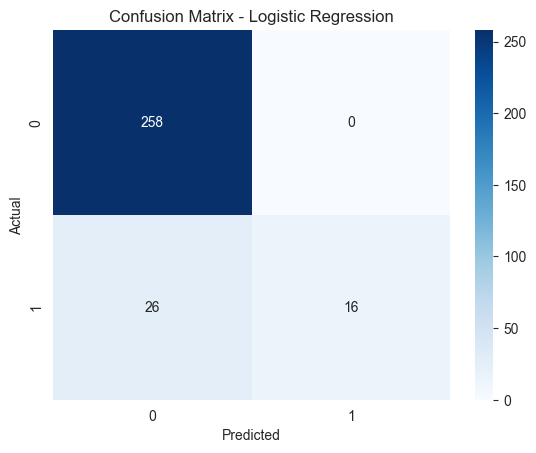


=== Random Forest ===
Accuracy: 0.9366666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       258
           1       0.96      0.57      0.72        42

    accuracy                           0.94       300
   macro avg       0.95      0.78      0.84       300
weighted avg       0.94      0.94      0.93       300


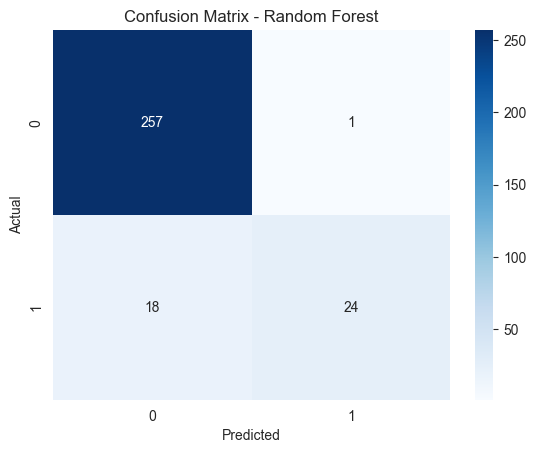

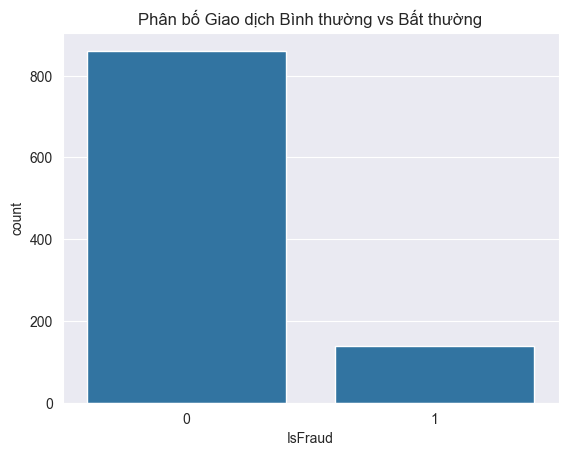

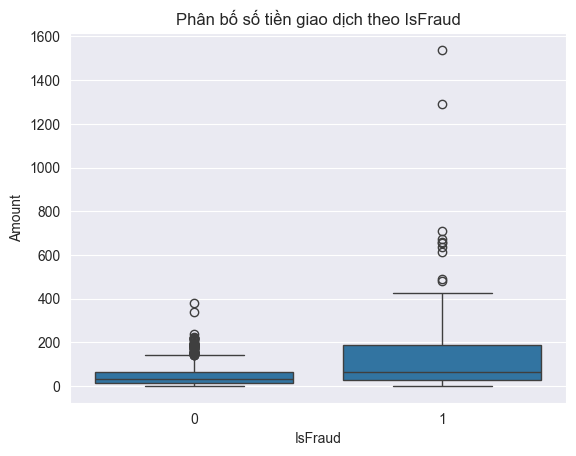

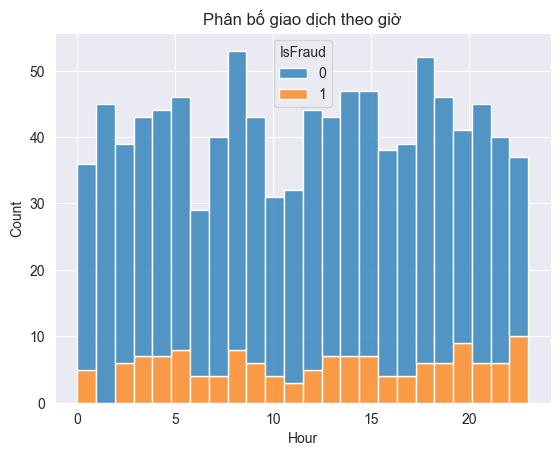

File kết quả đã lưu: /Users/nguyencongtri/PycharmProjects/MachineLearning/Project/data/transactions_1000_with_predictions.csv


In [4]:
# --- IMPORT ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. ĐỌC FILE DỮ LIỆU ---
input_file = "/Users/nguyencongtri/PycharmProjects/MachineLearning/Project/transactions_1000.csv"
df = pd.read_csv(input_file, parse_dates=["Time"])

# --- 2. THỰC HIỆN GÁN NHÃN 5-10% GIAO DỊCH BẤT THƯỜNG ---
df["Reason"] = ""  # cột mô tả nguyên nhân

# Chọn ngẫu nhiên 5-10% giao dịch làm bất thường
num_fraud = random.randint(int(len(df)*0.05), int(len(df)*0.1))
fraud_indices = np.random.choice(df.index, size=num_fraud, replace=False)

for idx in fraud_indices:
    reason_list = []
    
    amount = df.loc[idx, "Amount"]
    hour = df.loc[idx, "Time"].hour
    device = df.loc[idx, "Device"]
    location = df.loc[idx, "Location"]
    user = df.loc[idx, "UserID"]

    # Rule 1: Số tiền bất thường
    if amount > 200:
        reason_list.append("Giao dịch số tiền lớn bất thường")

    # Rule 2: Địa điểm nước ngoài
    if random.random() < 0.4:
        df.loc[idx, "Location"] = random.choice(["Singapore", "Tokyo", "New York"])
        reason_list.append("Giao dịch tại địa điểm nước ngoài")

    # Rule 3: Giao dịch lúc nửa đêm
    if hour < 5:
        reason_list.append("Giao dịch lúc nửa đêm")

    # Rule 4: Thiết bị bất thường
    if device == "POS" and random.random() < 0.5:
        reason_list.append("Thiết bị giao dịch bất thường (POS)")

    # Rule 5: Tần suất cao
    user_tx = df[df["UserID"] == user]
    if len(user_tx) > 20 and random.random() < 0.3:
        reason_list.append("Tần suất giao dịch cao bất thường")

    if len(reason_list) == 0:
        reason_list.append("Hành vi giao dịch bất thường")

    df.loc[idx, "IsFraud"] = 1
    df.loc[idx, "Reason"] = "; ".join(reason_list)

# --- 3. XỬ LÝ DỮ LIỆU CHO MÔ HÌNH ---
df['Hour'] = df['Time'].dt.hour
le_location = LabelEncoder()
df['Location_enc'] = le_location.fit_transform(df['Location'])
le_device = LabelEncoder()
df['Device_enc'] = le_device.fit_transform(df['Device'])

features = ['Amount', 'Hour', 'Location_enc', 'Device_enc']
X = df[features]
y = df['IsFraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. HUẤN LUYỆN MÔ HÌNH ---
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- 5. ĐÁNH GIÁ MÔ HÌNH ---
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# --- 6. BIỂU ĐỒ THỐNG KÊ ---
# Phân bố giao dịch bình thường vs bất thường
sns.countplot(x='IsFraud', data=df)
plt.title("Phân bố Giao dịch Bình thường vs Bất thường")
plt.show()

# Số tiền trung bình theo IsFraud
sns.boxplot(x='IsFraud', y='Amount', data=df)
plt.title("Phân bố số tiền giao dịch theo IsFraud")
plt.show()

# Giao dịch theo giờ
sns.histplot(data=df, x='Hour', hue='IsFraud', multiple='stack', bins=24)
plt.title("Phân bố giao dịch theo giờ")
plt.show()

# --- 7. LƯU KẾT QUẢ DỰ ĐOÁN ---
output_dir = "/Users/nguyencongtri/PycharmProjects/MachineLearning/Project/data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df['Pred_RF'] = rf_model.predict(X_scaled)

output_file = os.path.join(output_dir, "transactions_1000_with_predictions.csv")
df.to_csv(output_file, index=False)
print(f"File kết quả đã lưu: {output_file}")
